In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
base_image_path = "jacobs.jpg"
style_reference_image_path = "gogh.jpg"

total_variation_weight = 1.0
style_weight = 100.0
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [4]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [5]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [6]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [7]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [9]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.reshape(inp, (3, -1))
inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0

150528


In [10]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.


Epoch 1/100
1/1 [==============================] - 0s - loss: 17943.8105
Epoch 2/100
1/1 [==============================] - 0s - loss: 17781.1992
Epoch 3/100
1/1 [==============================] - 0s - loss: 17622.6465
Epoch 4/100
1/1 [==============================] - 0s - loss: 17467.6055
Epoch 5/100
1/1 [==============================] - 0s - loss: 17315.5254
Epoch 6/100
1/1 [==============================] - 0s - loss: 17166.1035
Epoch 7/100
1/1 [==============================] - 0s - loss: 17019.5645
Epoch 8/100
1/1 [==============================] - 0s - loss: 16875.9004
Epoch 9/100
1/1 [==============================] - 0s - loss: 16734.2188
Epoch 10/100
1/1 [==============================] - 0s - loss: 16594.6602
Epoch 11/100
1/1 [==============================] - 0s - loss: 16457.1895
Epoch 12/100
1/1 [==============================] - 0s - loss: 16322.5078
Epoch 13/100
1/1 [==============================] - 0s - loss: 16190.6826
Epoch 14/100
1/1 [=============================

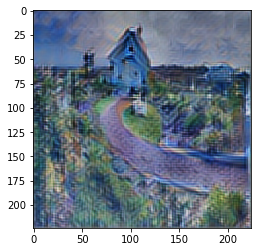

Epoch 1/100
1/1 [==============================] - 0s - loss: 10361.5586
Epoch 2/100
1/1 [==============================] - 0s - loss: 10329.0420
Epoch 3/100
1/1 [==============================] - 0s - loss: 10297.1328
Epoch 4/100
1/1 [==============================] - 0s - loss: 10265.8008
Epoch 5/100
1/1 [==============================] - 0s - loss: 10234.8115
Epoch 6/100
1/1 [==============================] - 0s - loss: 10204.2119
Epoch 7/100
1/1 [==============================] - 0s - loss: 10173.8633
Epoch 8/100
1/1 [==============================] - 0s - loss: 10143.8672
Epoch 9/100
1/1 [==============================] - 0s - loss: 10114.2266
Epoch 10/100
1/1 [==============================] - 0s - loss: 10084.9316
Epoch 11/100
1/1 [==============================] - 0s - loss: 10056.0820
Epoch 12/100
1/1 [==============================] - 0s - loss: 10027.6816
Epoch 13/100
1/1 [==============================] - 0s - loss: 9999.5391
Epoch 14/100
1/1 [==============================

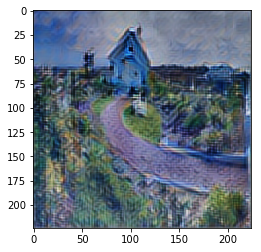

Epoch 1/100
1/1 [==============================] - 0s - loss: 8310.3301
Epoch 2/100
1/1 [==============================] - 0s - loss: 8297.0039
Epoch 3/100
1/1 [==============================] - 0s - loss: 8283.7812
Epoch 4/100
1/1 [==============================] - 0s - loss: 8270.7285
Epoch 5/100
1/1 [==============================] - 0s - loss: 8257.6982
Epoch 6/100
1/1 [==============================] - 0s - loss: 8244.7744
Epoch 7/100
1/1 [==============================] - 0s - loss: 8231.9385
Epoch 8/100
1/1 [==============================] - 0s - loss: 8219.1611
Epoch 9/100
1/1 [==============================] - 0s - loss: 8206.4824
Epoch 10/100
1/1 [==============================] - 0s - loss: 8193.8115
Epoch 11/100
1/1 [==============================] - 0s - loss: 8181.3223
Epoch 12/100
1/1 [==============================] - 0s - loss: 8168.8755
Epoch 13/100
1/1 [==============================] - 0s - loss: 8156.6211
Epoch 14/100
1/1 [==============================] - 0s - los

KeyboardInterrupt: 

In [14]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 100)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [ ]:
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

(224, 224, 3)


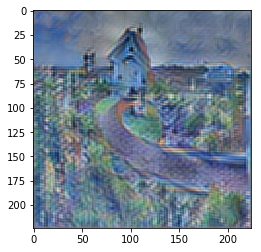

In [13]:
img = generative_model.predict( np.random.rand(1, 150528))
img = img[0]
imgB = img.swapaxes(0, 2).swapaxes(0, 1)
print imgB.shape
plt.imshow(imgB)
# plt.show()

In [82]:
def get_train_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    trainX = np.reshape(inp, (1, 3, 224, 224))
    trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
    trainX3 = trainX/256.0
    return trainX3